In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os


from smoothness_2 import sparc
from smoothness_2 import dimensionless_jerk2
from smoothness import spectral_arclength
from smoothness import dimensionless_jerk
from for_paper import plot_different_tasks
from mouvements import data_span

from pylab import *
from scipy import misc

In [62]:
class Marker:
    x = 0
    y = 0
    z = 0 
    mrk= ''
    col= ''
    name = ''
    number =0
    
    def __init__(self, x,y,z,mrk,col,name,number):      
        self.x = x
        self.y = y
        self.z = z
        self.mrk=mrk
        self.col=col
        self.name = name
        self.number = number
    
    def plot (self, ax, with_names, with_numbers, isHead):
        #ax.scatter(self.x,self.y,self.z,s=50, marker='d', color="g")   
        if isHead==True:
            ax.scatter(self.x,self.y,self.z,s=150, marker=self.mrk, color=self.col)     
        else:
            ax.scatter(self.x,self.y,self.z,s=50, marker=self.mrk, color=self.col) 
        if with_names==True:
            ax.text(self.x,self.y,self.z,'%s' % (self.name), size=5, zorder=1,)
        if with_numbers==True:
            ax.text(self.x,self.y,self.z, '%s''%s' % ('  ',self.number), size=5, zorder=1,)

In [63]:
class Link: 
    marker1 = None
    marker2 = None
    color = 'k'
  
    def __init__(self, marker1, marker2, color):      
        self.marker1 = marker1
        self.marker2 = marker2
        self.color = color
        
        
    def plot(self,ax):
        X= [self.marker1.x , self.marker2.x]
        Y= [self.marker1.y , self.marker2.y]
        Z= [self.marker1.z , self.marker2.z]
        ax.plot(X,Y,Z, color=self.color)

In [64]:
class Skeleton: 
    markers = []
    links = []
    dafr = pd.DataFrame ()
    linkRight= []
    linkLeft = []
    linkAxial = []
    markerNames =[]
    
    
    
    def __init__(self, dafr, linkRight, linkLeft, linkAxial, markerNames):     
        #build the markers
        if self.markers:
            self.markers.clear()
        if self.links:
            self.links.clear()
        nMarkers = len(dafr.columns)
        for i in range (0,nMarkers): 
            markerNum = dafr.columns[i]
            x=dafr.loc[:,markerNum][0]
            z=dafr.loc[:,markerNum][1]
            y=dafr.loc[:,markerNum][2]
            if i==4:
                marker = Marker (x,y,z,'o',"k",markerNames[i-1],i+1)
            else :
                marker = Marker (x,y,z,'d',"g",markerNames[i-1],i+1)
            self.markers.append(marker)
        #build the links
        links_num=[linkRight, linkLeft, linkAxial]
        for n in range (3) :
            links_=links_num[n]
            for k in range (0,len(links_)) :
                xx= np.array (dafr.loc[:,links_[k]].loc['x',:])
                x1= xx[0]; x2 =xx[1]
                yy=np.array(dafr.loc[:,links_[k]].loc['z',:])
                y1= yy[0]; y2 = yy[1]
                zz= np.array (dafr.loc[:,links_[k]].loc['y',:])
                z1= zz[0]; z2 = zz[1]
                number1 = links_[k][0]-1 ; number2 = links_[k][1]-1
                name1 = markerNames[number1] ; name2 = markerNames[number2]
                marker1= Marker (x1,y1,z1,'d',"g",name1, number1)
                marker2= Marker (x2,y2,z2,'d',"g",name2, number2)
                if n==0 : 
                    link= Link(marker1,marker2,'b')
                    self.links.append(link)
                if n==1 : 
                    link= Link(marker1,marker2,'r')
                    self.links.append(link)
                if n==2 : 
                    link= Link(marker1,marker2,'k')
                    self.links.append(link)
        
    def plot(self, ax, with_names, with_numbers):
        #all markers
        #on peut definir  with_names et with_numbers comme des tableaux de true 
        #et false si on veut specifier quel marker afficher ou non
        nMarkers = len(self.markers)
        for i in range (0,nMarkers):
            self.markers[i].plot(ax,with_names, with_numbers,i==4)
        #links
        nLinks = len(self.links)
        for j in range (0,nLinks) :
            link = self.links[j]
            link.plot(ax)

In [65]:
class SkeletonInMotion:
    dataTxt=None
    localDir = ''
    fileData = ''
    Frame=None
    
    def __init__(self, localDir, fileData): 
        os.chdir(localDir)
        self.dataTxt=pd.read_excel(fileData, sheet_name ="Segment Position")
        self.Frame=self.dataTxt.loc[:,'Frame']
        
    def get_t_df (self, t):
        l=self.dataTxt.shape[1]
        datax=[]; datay=[]; dataz=[]
        for i in range (1,l,3):
            datax.append(self.dataTxt.loc[:,self.dataTxt.columns[i]][t])  #extract all the x's from the first column and store them in datax list
            datay.append(self.dataTxt.loc[:,self.dataTxt.columns[i+1]][t])  #extract all the y's from the first column and store them in datay list
            dataz.append(self.dataTxt.loc[:,self.dataTxt.columns[i+2]][t])  #extract all the z's from the first column and store them in dataz list
        ar=np.array([datax,datay,dataz])
        df = pd.DataFrame(ar, index = ['x', 'y', 'z'], columns = ['Pelvis','L5','L3','T12','T8','Neck','Head','Right Shoulder','Right Upper Arm','Right Forearm','Right Hand','Left Shoulder','Left Upper Arm','Left Forearm','Left Hand','Right Upper Leg','Right Lower Leg','Right Foot','Right Toe','Left Upper Leg','Left Lower Leg','Left Foot','Left Toe'])
        return df
        
    def animate(self, t):
        df= self.get_t_df (t)
        ax = plt.axes(projection='3d')
        ax.set_xlim3d(150,400)
        ax.set_zlim3d(0, 180)
        ax.set_ylim3d(-100, 0)  
        skeleton = Skeleton (df,links_right,links_left,links_axial,marker_names)
        skeleton.plot(ax,False,False)
        
        
            
    def start_ani(self, MyFig):
        #self.writer = animation.FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)
        self.ani = matplotlib.animation.FuncAnimation(MyFig, self.animate, frames=int(self.dataTxt.shape[0]), repeat=False)
   
    def L_filling (self, L) :
        #Permet de récupérer toutes les lignes du fichier txt (data)
        for i in range (len(L)) :
            L[i].append(self.dataTxt.loc[:,self.dataTxt.columns[i]])
        #Remplissage des vecteurs vides
        for i in range (len(L)) :
            L[i]= np.array (L[i])
            L[i]=L[i].transpose()
        return L
            
    def Characteristics (self,L) :
        #### Vérification de la lecture du fichier par visualisation ####
        
        for i in range (len(marker_names)) :
            
            if i==0 : j=i
            else : j=i*3
            
            L1=L[j]
            L2=L[j+1]
            L3=L[j+2]
            
            fig,ax=plt.subplots(2,2,num = marker_names[i])
            fig.suptitle(marker_names[i])
            
            L4=[]
            
            for  k in range(len(L1)) :
                L4.append (np.sqrt (L1[k] * L1[k] + L2[k] *L2[k] + L3[k] *L3[k]))
        
            ax[0,0].set_title('Mouvement en fonction du temps')

            ax[0,0].plot(self.Frame,L4,color='r')
            #ax[0,0].set(xlabel='Frame')
            ax[0,0].set(ylabel='Amplitude')
            #ax[0,0].legend()
            
            
            #### CALCULS DE DERIVEES ####
            #### Calcul de la vitesse (à partir des positions) ####
            #Dérivée position = vitesse
    
            l = len(L4)
            Vitesse = [b-a for b,a in zip(L4[1:l],L4[0:(l-1)])]
            ax[0,1].set_title('Vitesse')
            F=self.Frame[0:(len(self.Frame)-1)]
            ax[0,1].plot(F,Vitesse)
            #ax[0,1].set(xlabel='Frame')
            ax[0,1].set(ylabel='Vitesse')
    
    
    
    
            #### Calcul de l'accélération (à partir de la vitesse) ####
            #Dérivée vit = acc
    
            l = len(Vitesse)
            Acc = [b-a for b,a in zip(Vitesse[1:l],Vitesse[0:(l-1)])]
            ax[1,0].set_title('Accélération')
            F=self.Frame[0:(len(self.Frame)-2)]
            ax[1,0].plot(F,Acc, color ='y')
            ax[1,0].set(xlabel='Frame')
            ax[1,0].set(ylabel='Accélération')
    
    
    
            #### Calcul des secousses (jerk) (à partir de l'accélération) ####
            # Dérivée acc = jerk
    
            l = len(Acc)
            Jerk = [b-a for b,a in zip(Acc[1:l],Acc[0:(l-1)])]
            ax[1,1].set_title('Secousses')
            F=self.Frame[0:(len(self.Frame)-3)]
            ax[1,1].plot(F,Jerk, color='g')
            ax[1,1].set(xlabel='Frame')
            ax[1,1].set(ylabel='Jerk')
            
            
            
            
    
        # fs = 60
        # SAL_Pelvis_x = sparc(Pelvis_x, fs)[0]  #[0] --> Permet d'afficher le premier élément que la fonction retourne
        # SAL_Pelvis_y = sparc(Pelvis_y, fs)[0]
        # SAL_Pelvis_z = sparc(Pelvis_z, fs)[0]
            
        # print('Métrique de la fluidité (X)',SAL_Pelvis_x)
        # print('Métrique de la fluidité (Y)',SAL_Pelvis_y)
        # print('Métrique de la fluidité (Z)',SAL_Pelvis_z)
    
    
   
    
        # #Calculation of the jerk (dimensionless --> )
            
        # Jerk_Pelvis_x = dimensionless_jerk(Pelvis_x, fs)
        # Jerk_Pelvis_y = dimensionless_jerk(Pelvis_y, fs)
        # Jerk_Pelvis_z = dimensionless_jerk(Pelvis_z, fs)
            
        # print ('Métrique des secousses (X)', Jerk_Pelvis_x)
        # print ('Métrique des secousses (Y)', Jerk_Pelvis_y)
        # print ('Métrique des secousses (Z)', Jerk_Pelvis_z)
    



In [66]:
links_right=np.array([['Neck', 'Right Shoulder'],['Right Upper Arm', 'Right Shoulder'],['Right Forearm','Right Hand'],['Right Forearm','Right Upper Arm'],['Right Upper Leg', 'Right Lower Leg'],['Right Upper Leg', 'Pelvis'],['Right Foot', 'Right Lower Leg'],['Right Foot', 'Right Toe']])
links_left=np.array([['Left Forearm','Left Hand'],['Left Forearm','Left Upper Arm'],['Neck', 'Left Shoulder'],['Left Upper Arm', 'Left Shoulder'],['Left Upper Leg', 'Pelvis'],['Left Foot', 'Left Lower Leg'],['Left Foot', 'Left Toe'],['Left Upper Leg', 'Left Lower Leg']])
links_axial=np.array([['Neck', 'Head'],['T8', 'Neck'],['T12', 'T8'],['L3', 'T12'],['L3', 'L5'],['L5', 'Pelvis']])
links_num=[links_right,links_left,links_axial]
marker_names=['Pelvis','L5','L3','T12','T8','Neck','Head','Right Shoulder','Right Upper Arm','Right Forearm','Right Hand','Left Shoulder','Left Upper Arm','Left Forearm','Left Hand','Right Upper Leg','Right Lower Leg','Right Foot','Right Toe','Left Upper Leg','Left Lower Leg','Left Foot','Left Toe']
Pelvis_x , Pelvis_y , Pelvis_z , L5_x,L5_y,L5_z, L3_x,L3_y,L3_z, T12_x,T12_y,T12_z, T8_x,T8_y,T8_z,  Neck_x , Neck_y , Neck_z ,Head_x , Head_y , Head_z , R_Shoulder_x , R_Shoulder_y , R_Shoulder_z ,  R_U_Arm_x , R_U_Arm_y , R_U_Arm_z , R_Forearm_x , R_Forearm_y , R_Forearm_z , R_Hand_x , R_Hand_y , R_Hand_z ,  L_Shoulder_x ,L_Shoulder_y,L_Shoulder_z  , L_U_Arm_x , L_U_Arm_y , L_U_Arm_z , L_Forearm_x , L_Forearm_y , L_Forearm_z , L_Hand_x , L_Hand_y , L_Hand_z , R_U_Leg_x , R_U_Leg_y , R_U_Leg_z , R_L_Leg_x , R_L_Leg_y ,R_L_Leg_z , R_Foot_x ,R_Foot_y , R_Foot_z ,R_Toe_x , R_Toe_y,R_Toe_z,  L_U_Leg_x , L_U_Leg_y , L_U_Leg_z , L_L_Leg_x , L_L_Leg_y , L_L_Leg_z , L_Foot_x , L_Foot_y , L_Foot_z ,L_Toe_x,L_Toe_y,L_Toe_z = ([] for i in range (69)) 
L= [ Pelvis_x , Pelvis_y , Pelvis_z , L5_x,L5_y,L5_z, L3_x,L3_y,L3_z, T12_x,T12_y,T12_z, T8_x,T8_y,T8_z,  Neck_x , Neck_y , Neck_z ,Head_x , Head_y , Head_z , R_Shoulder_x , R_Shoulder_y , R_Shoulder_z ,  R_U_Arm_x , R_U_Arm_y , R_U_Arm_z , R_Forearm_x , R_Forearm_y , R_Forearm_z , R_Hand_x , R_Hand_y , R_Hand_z ,  L_Shoulder_x ,L_Shoulder_y,L_Shoulder_z  , L_U_Arm_x , L_U_Arm_y , L_U_Arm_z , L_Forearm_x , L_Forearm_y , L_Forearm_z , L_Hand_x , L_Hand_y , L_Hand_z , R_U_Leg_x , R_U_Leg_y , R_U_Leg_z , R_L_Leg_x , R_L_Leg_y ,R_L_Leg_z , R_Foot_x ,R_Foot_y , R_Foot_z ,R_Toe_x , R_Toe_y,R_Toe_z,  L_U_Leg_x , L_U_Leg_y , L_U_Leg_z , L_L_Leg_x , L_L_Leg_y , L_L_Leg_z , L_Foot_x , L_Foot_y , L_Foot_z ,L_Toe_x,L_Toe_y,L_Toe_z ]

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_12632\4161735270.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(2,2,num = marker_names[i])


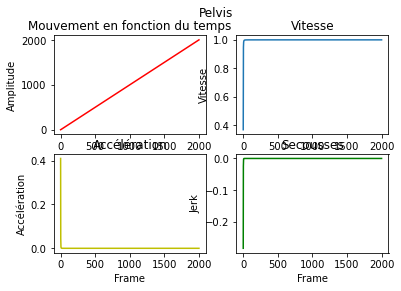

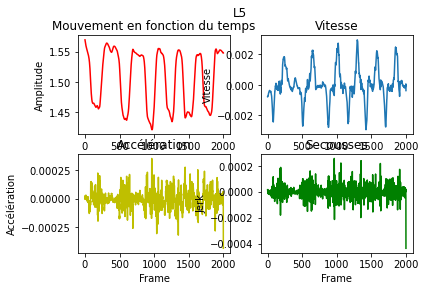

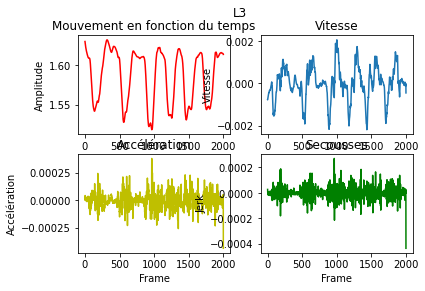

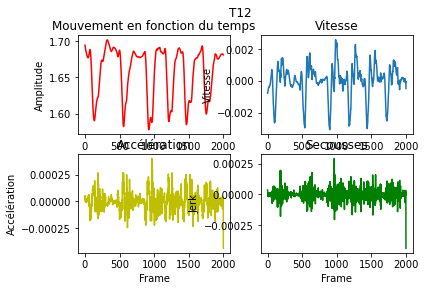

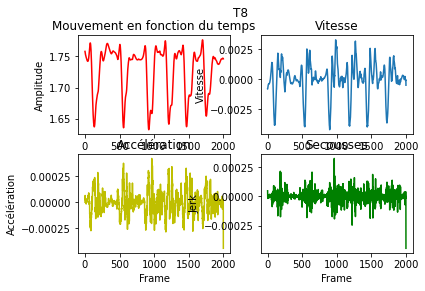

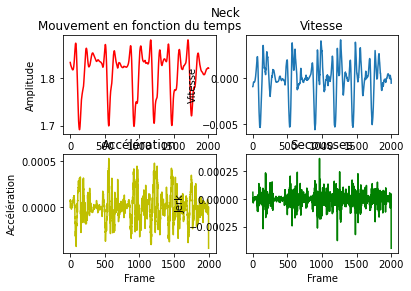

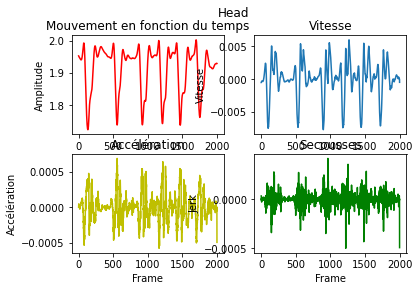

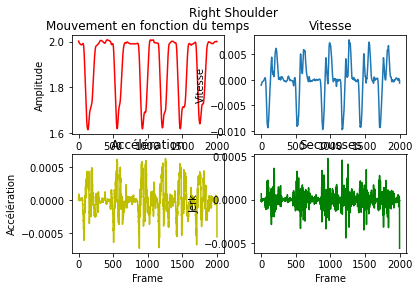

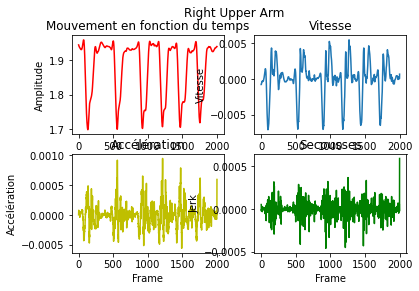

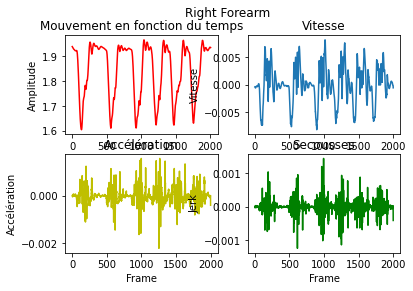

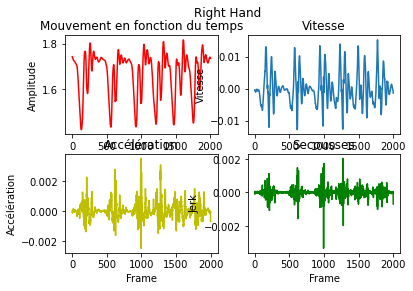

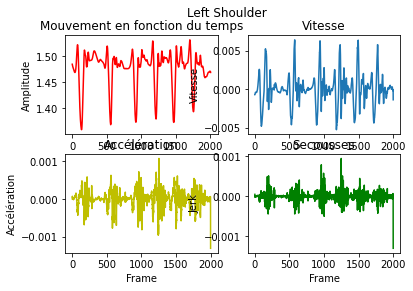

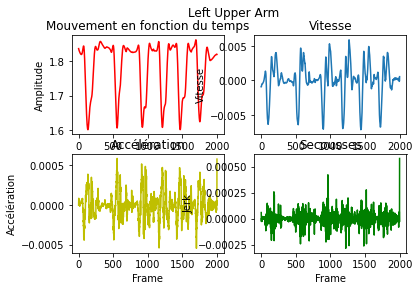

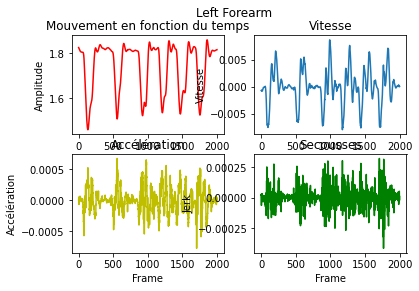

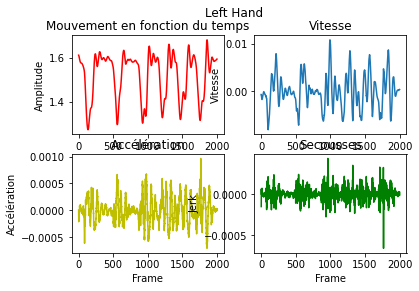

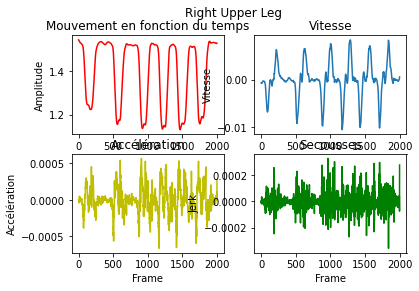

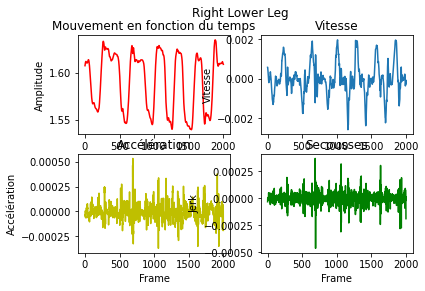

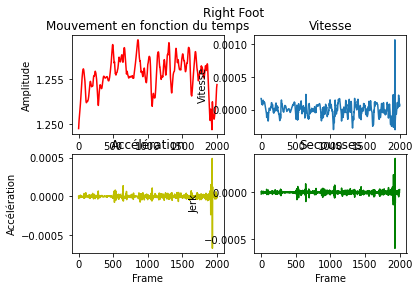

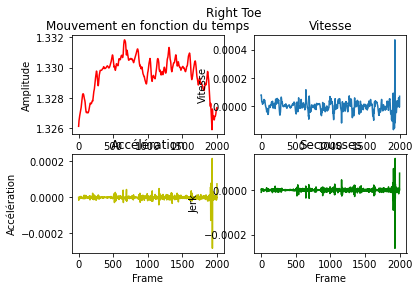

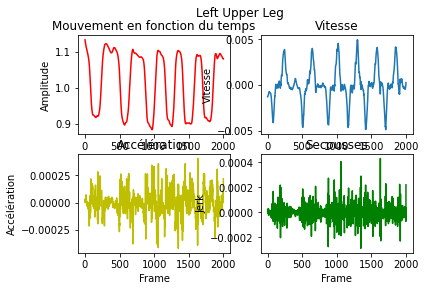

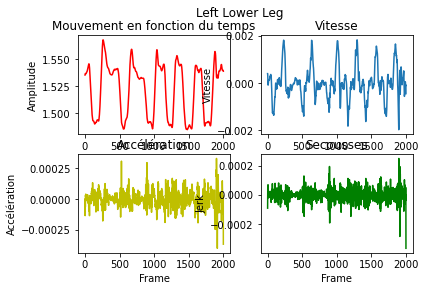

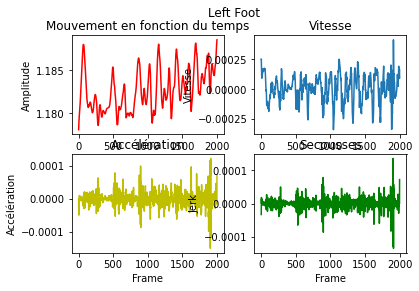

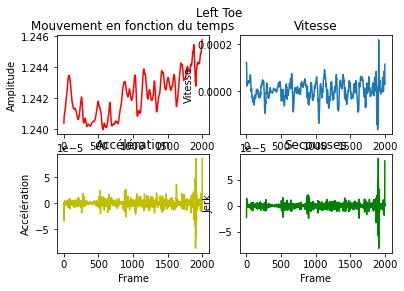

In [67]:
#fig = plt.figure(figsize=(10,10))
    
sm = SkeletonInMotion('C:/Users/Administrateur/Downloads','014_MoLu-002.xlsx') 


#sm.start_ani(fig)

L = sm.L_filling(L)
sm.Characteristics(L) 